## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc
from IPython.display import Image
import os

In [2]:

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns',5000)

encoder = LabelEncoder()
from IPython.display import Image
import os

## Import Dataset

In [9]:
path = "./Data/"

In [11]:
train = pd.read_csv(path + 'train.csv')
campaign = pd.read_csv(path + 'campaign_data.csv')
items = pd.read_csv(path + 'item_data.csv')
coupons = pd.read_csv(path + 'coupon_item_mapping.csv')
cust_demo = pd.read_csv(path + 'customer_demographics.csv')
cust_tran = pd.read_csv(path + 'customer_transaction_data.csv')
test = pd.read_csv(path + 'test.csv')

## Exploring the Data

In [12]:
train.shape, campaign.shape, items.shape, coupons.shape, cust_demo.shape, cust_tran.shape, test.shape

((78369, 5),
 (28, 4),
 (74066, 4),
 (92663, 2),
 (760, 7),
 (1324566, 7),
 (50226, 4))

In [13]:
print('Train Dataframe')
print(train.isnull().sum())
print('======================')
print('Campaign Dataframe')
print(campaign.isnull().sum())
print('======================')
print('Items Dataframe')
print(items.isnull().sum())
print('======================')
print('Coupons Dataframe')
print(coupons.isnull().sum())
print('======================')
print('Customer Demographics Dataframe')
print(cust_demo.isnull().sum())
print('======================')
print('Customer Transaction Dataframe')
print(cust_tran.isnull().sum())
print('======================')

print(test.isnull().sum())

Train Dataframe
id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64
Campaign Dataframe
campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
Items Dataframe
item_id       0
brand         0
brand_type    0
category      0
dtype: int64
Coupons Dataframe
coupon_id    0
item_id      0
dtype: int64
Customer Demographics Dataframe
customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
Customer Transaction Dataframe
date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64
id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64


In [14]:
train.head()

id  campaign_id  coupon_id  customer_id  redemption_status
0   1           13         27         1053                  0
1   2           13        116           48                  0
2   6            9        635          205                  0
3   7           13        644         1050                  0
4   9            8       1017         1489                  0

In [15]:
train.redemption_status.value_counts(normalize=True)*100

0    99.069785
1     0.930215
Name: redemption_status, dtype: float64

Text(0, 0.5, 'redemption_status')

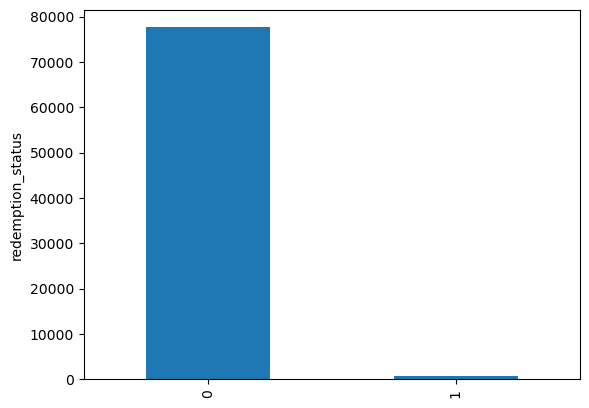

In [16]:
value=train['redemption_status'].value_counts().plot(kind='bar')
plt.ylabel('redemption_status')

## Cleaning and Preprocessing the Data

In [17]:
cust_demo.head()

customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2            NaN   
1            6     46-55        Married       0           2            NaN   
2            7     26-35            NaN       0           3              1   
3            8     26-35            NaN       0           4              2   
4           10     46-55         Single       0           1            NaN   

   income_bracket  
0               4  
1               5  
2               3  
3               6  
4               5

In [18]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [19]:
cust_demo.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [20]:
cust_demo.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [21]:
cust_demo.no_of_children.value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [22]:
cust_demo['family_size'] = cust_demo.family_size.apply(lambda x: int(re.sub('\+','',x)))
cust_demo['no_of_children'] = cust_demo.no_of_children.apply(lambda x: int(re.sub('\+','',x)) if pd.notna(x) else x)

In [23]:
#Filling NaN values for marital_status

#customers with family size =1 will be single
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (cust_demo.family_size == 1),'marital_status'] = 'Single'

#customers whos family size - no of childrens == 1, will also be single 
#This is applicable where there is only 1 parent --- We treat 1 parent as Single
cust_demo.loc[(cust_demo.family_size - cust_demo.no_of_children == 1) & pd.isnull(cust_demo.marital_status),'marital_status'] = 'Single'

#from the orignal data we have 186 of 196 customers with diff of 2 in their family size and number of childrens as
#Married (see the below cell) and hence where ever the difference is 2 and marital status is NaN and No of Children is 
#NaN we impute the Mariatl Status with Married
cust_demo.loc[(pd.isnull(cust_demo.marital_status)) & ((cust_demo.family_size - cust_demo.no_of_children) == 2)  
              & (pd.notnull(cust_demo.no_of_children)),'marital_status'] = 'Married'

#original data shows customers with fam size == 2, and NaN in no of childrens are majorly Married (see below cell skipping 1 cell)
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (pd.isnull(cust_demo.no_of_children)) 
              & (cust_demo.family_size ==2),'marital_status'] = 'Married'

In [24]:
a = cust_demo.marital_status.groupby((cust_demo.family_size - cust_demo.no_of_children) == 2).value_counts()
print(a[True])

marital_status
Married    186
Single      10
Name: marital_status, dtype: int64


In [25]:
cust_demo.marital_status.isnull().sum()

0

In [26]:
#FillingNaN values for no of children

#Married people with family_size ==2 will have 0 childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.marital_status == 'Married') & (cust_demo.family_size == 2),'no_of_children'] = 0

#customers with family size 1 will have zero childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 1), 'no_of_children'] = 0

#singles with family size == 2, will probably have 1 child
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 2),'no_of_children'] = 1

cust_demo['no_of_children']=cust_demo['no_of_children'].astype(np.int64)

In [27]:
cust_demo.no_of_children.isnull().sum()

0

In [28]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  760 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    int64 
 5   no_of_children  760 non-null    int64 
 6   income_bracket  760 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 41.7+ KB


In [29]:
#Label Encoding Marital Status --- 0 is Single and 1 is Married
cust_demo["marital_status"] = encoder.fit_transform(cust_demo["marital_status"])

In [30]:
# Label Encoding age_range ... 18-25 is 0, 26-35 is 1, 36-45 is 2, 46-55 is 3, 56-70 is 4 and 70+ is 5
cust_demo["age_range"] = encoder.fit_transform(cust_demo["age_range"])

In [31]:
cust_demo.head()

customer_id  age_range  marital_status  rented  family_size  \
0            1          5               0       0            2   
1            6          3               0       0            2   
2            7          1               0       0            3   
3            8          1               0       0            4   
4           10          3               1       0            1   

   no_of_children  income_bracket  
0               0               4  
1               0               5  
2               1               3  
3               2               6  
4               0               5

### For Campaign Dataset

In [32]:
campaign.head()

campaign_id campaign_type start_date  end_date
0           24             Y   21/10/13  20/12/13
1           25             Y   21/10/13  22/11/13
2           20             Y   07/09/13  16/11/13
3           23             Y   08/10/13  15/11/13
4           21             Y   16/09/13  18/10/13

In [33]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [34]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [35]:
campaign["campaign_type"] = encoder.fit_transform(campaign.campaign_type)

In [36]:
#Converting the date columns to date time
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [37]:
#Creating a new column campaign_duration
campaign["campaign_duration"] = campaign["end_date"] - campaign["start_date"]
campaign["campaign_duration"] = campaign["campaign_duration"].apply(lambda x: x.days) 

In [38]:
campaign.head()

campaign_id  campaign_type start_date   end_date  campaign_duration
0           24              1 2013-10-21 2013-12-20                 60
1           25              1 2013-10-21 2013-11-22                 32
2           20              1 2013-09-07 2013-11-16                 70
3           23              1 2013-10-08 2013-11-15                 38
4           21              1 2013-09-16 2013-10-18                 32

### For Customer Txn Dataframe

In [39]:
cust_tran.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0  2012-01-02         1501    26830         1          35.26          -10.69   
1  2012-01-02         1501    54253         1          53.43          -13.89   
2  2012-01-02         1501    31962         1         106.50          -14.25   
3  2012-01-02         1501    33647         1          67.32            0.00   
4  2012-01-02         1501    48199         1          71.24          -28.14   

   coupon_discount  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [40]:
cust_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [41]:
cust_tran['date'] = pd.to_datetime(cust_tran['date'])
cust_tran = cust_tran.sort_values('date').reset_index(drop=True)

In [42]:
cust_tran.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1          35.26          -10.69   
1 2012-01-02          464    20697         1          92.26          -21.37   
2 2012-01-02          464    20717         2          28.50          -27.78   
3 2012-01-02          464    21008         1          35.26          -17.81   
4 2012-01-02          464    22243         2         118.97          -22.80   

   coupon_discount  
0             0.00  
1           -35.62  
2             0.00  
3             0.00  
4             0.00

In [43]:
cust_tran['day'] = cust_tran["date"].apply(lambda x: x.day)
cust_tran['dow'] = cust_tran["date"].apply(lambda x: x.weekday())
cust_tran['month'] = cust_tran["date"].apply(lambda x: x.month)

In [44]:
cust_tran.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1          35.26          -10.69   
1 2012-01-02          464    20697         1          92.26          -21.37   
2 2012-01-02          464    20717         2          28.50          -27.78   
3 2012-01-02          464    21008         1          35.26          -17.81   
4 2012-01-02          464    22243         2         118.97          -22.80   

   coupon_discount  day  dow  month  
0             0.00    2    0      1  
1           -35.62    2    0      1  
2             0.00    2    0      1  
3             0.00    2    0      1  
4             0.00    2    0      1

In [45]:
cust_tran.selling_price = cust_tran.selling_price/cust_tran.quantity
cust_tran.other_discount = cust_tran.other_discount/cust_tran.quantity
cust_tran.selling_price = cust_tran.selling_price - cust_tran.other_discount

In [46]:
cust_tran['coupon_used'] = cust_tran.coupon_discount.apply(lambda x: 1 if x !=0 else 0)

In [47]:
cust_tran.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1         45.950          -10.69   
1 2012-01-02          464    20697         1        113.630          -21.37   
2 2012-01-02          464    20717         2         28.140          -13.89   
3 2012-01-02          464    21008         1         53.070          -17.81   
4 2012-01-02          464    22243         2         70.885          -11.40   

   coupon_discount  day  dow  month  coupon_used  
0             0.00    2    0      1            0  
1           -35.62    2    0      1            1  
2             0.00    2    0      1            0  
3             0.00    2    0      1            0  
4             0.00    2    0      1            0

### For Item Dataset

In [48]:
items.head()

item_id  brand   brand_type       category
0        1      1  Established        Grocery
1        2      1  Established  Miscellaneous
2        3     56        Local         Bakery
3        4     56        Local        Grocery
4        5     56        Local        Grocery

In [49]:
items.brand_type.value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [50]:
items.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

In [51]:
items.brand_type = encoder.fit_transform(items["brand_type"])
items.category = encoder.fit_transform(items["category"])

In [52]:
items.head()

item_id  brand  brand_type  category
0        1      1           0         6
1        2      1           0         8
2        3     56           1         1
3        4     56           1         6
4        5     56           1         6

### For Coupon Dataset

In [53]:
coupons.head()

coupon_id  item_id
0        105       37
1        107       75
2        494       76
3        522       77
4        518       77

# Now, let's look at the schema

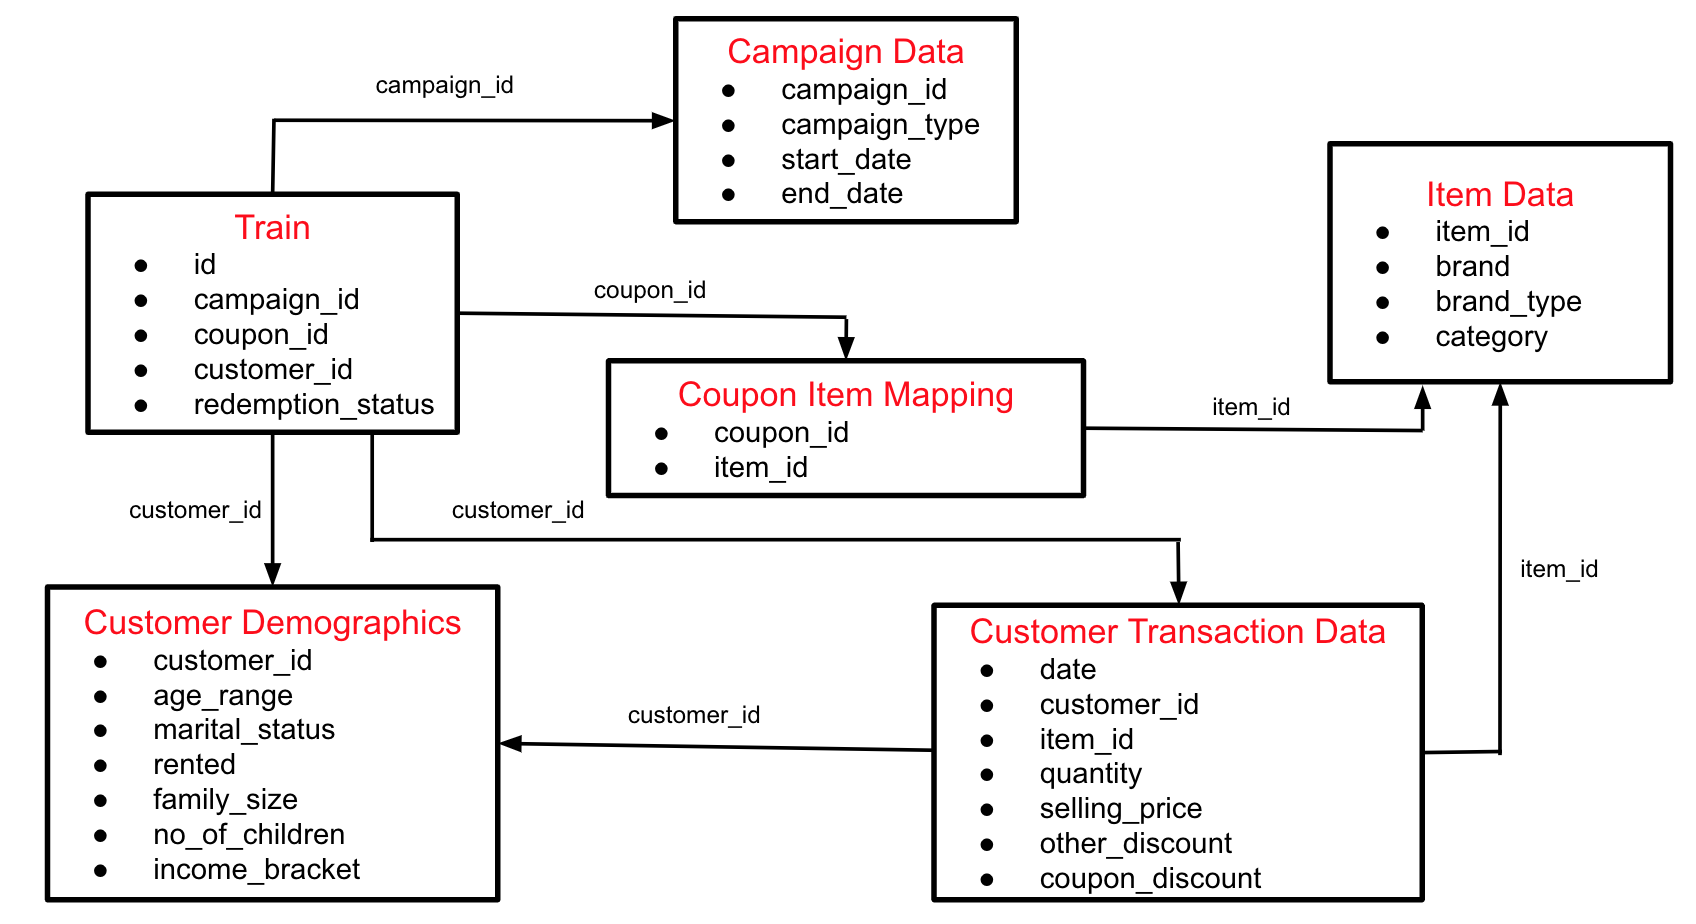

In [55]:
Image(path + "Schema.png")

## Now, let's merge the data

In [56]:
coupons_items = pd.merge(coupons, items, on="item_id", how="left")

In [57]:
coupons_items.head()

coupon_id  item_id  brand  brand_type  category
0        105       37     56           1         6
1        107       75     56           1         6
2        494       76    209           0         6
3        522       77    278           0         6
4        518       77    278           0         6

In [58]:
cust_tran.head()

date  customer_id  item_id  quantity  selling_price  other_discount  \
0 2012-01-02         1501    26830         1         45.950          -10.69   
1 2012-01-02          464    20697         1        113.630          -21.37   
2 2012-01-02          464    20717         2         28.140          -13.89   
3 2012-01-02          464    21008         1         53.070          -17.81   
4 2012-01-02          464    22243         2         70.885          -11.40   

   coupon_discount  day  dow  month  coupon_used  
0             0.00    2    0      1            0  
1           -35.62    2    0      1            1  
2             0.00    2    0      1            0  
3             0.00    2    0      1            0  
4             0.00    2    0      1            0

In [59]:
# Aggregate transactions by item_id by mean for a particular customer
transactions1 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum
                        } )
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers'}, inplace=True)

In [60]:
transactions1.head()

item_id  coupon_discount  coupon_used  no_of_customers  other_discount  \
0        1              0.0            0                2             0.0   
1        2              0.0            0                1             0.0   
2        3              0.0            0                1             0.0   
3        4              0.0            0                1             0.0   
4        5              0.0            0                1             0.0   

   quantity  selling_price  
0       1.0         124.31  
1       1.0          35.26  
2       1.0          56.64  
3       1.0          54.85  
4       1.0          81.57

In [61]:
# Aggregate transactions by item_id by sum for a particular customer
transactions2 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 't_counts', 'quantity':'qu_sum',
                             'selling_price':'price_sum', 'other_discount':'od_sum',
                             'coupon_discount':'cd_sum'}, inplace=True)

In [62]:
transactions2.head()

item_id  cd_sum  t_counts  od_sum  qu_sum  price_sum
0        1     0.0         2     0.0       2     248.62
1        2     0.0         1     0.0       1      35.26
2        3     0.0         1     0.0       1      56.64
3        4     0.0         1     0.0       1      54.85
4        5     0.0         1     0.0       1      81.57

In [63]:
transactions1 = pd.merge(transactions1, transactions2, on='item_id',how='left' )

In [64]:
transactions1['total_discount_mean'] = transactions1['coupon_discount'] + transactions1['other_discount']
transactions1['total_discount_sum'] = transactions1['od_sum'] + transactions1['cd_sum']
transactions1.head()

item_id  coupon_discount  coupon_used  no_of_customers  other_discount  \
0        1              0.0            0                2             0.0   
1        2              0.0            0                1             0.0   
2        3              0.0            0                1             0.0   
3        4              0.0            0                1             0.0   
4        5              0.0            0                1             0.0   

   quantity  selling_price  cd_sum  t_counts  od_sum  qu_sum  price_sum  \
0       1.0         124.31     0.0         2     0.0       2     248.62   
1       1.0          35.26     0.0         1     0.0       1      35.26   
2       1.0          56.64     0.0         1     0.0       1      56.64   
3       1.0          54.85     0.0         1     0.0       1      54.85   
4       1.0          81.57     0.0         1     0.0       1      81.57   

   total_discount_mean  total_discount_sum  
0                  0.0                 0.0  
1                  0.0                 0.0  
2                  0.0                 0.0  
3                  0.0                 0.0  
4                  0.0                 0.0

In [66]:
item_coupon_trans = pd.merge(coupons_items, transactions1, on='item_id', how='left')

In [67]:
item_coupon_trans.head()

coupon_id  item_id  brand  brand_type  category  coupon_discount  \
0        105       37     56           1         6              0.0   
1        107       75     56           1         6              0.0   
2        494       76    209           0         6              0.0   
3        522       77    278           0         6              0.0   
4        518       77    278           0         6              0.0   

   coupon_used  no_of_customers  other_discount  quantity  selling_price  \
0          0.0              2.0       -8.108333  2.285714      57.247381   
1          0.0              4.0       -2.633712  1.363636      38.828485   
2          0.0              1.0      -17.450000  1.000000     106.500000   
3          0.0              2.0      -16.920000  1.000000      87.270000   
4          0.0              2.0      -16.920000  1.000000      87.270000   

   cd_sum  t_counts     od_sum  qu_sum    price_sum  total_discount_mean  \
0     0.0       7.0 -56.758333    16.0   400.731667            -8.108333   
1     0.0      33.0 -86.912500    45.0  1281.340000            -2.633712   
2     0.0       1.0 -17.450000     1.0   106.500000           -17.450000   
3     0.0       2.0 -33.840000     2.0   174.540000           -16.920000   
4     0.0       2.0 -33.840000     2.0   174.540000           -16.920000   

   total_discount_sum  
0          -56.758333  
1          -86.912500  
2          -17.450000  
3          -33.840000  
4          -33.840000

In [68]:
item_coupon_trans.columns

Index(['coupon_id', 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'no_of_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
      dtype='object')

In [70]:
coupon = pd.pivot_table(
    item_coupon_trans,
    index="coupon_id",
    values=[
        'item_id', 'brand', 'brand_type', 'category', 'coupon_discount',
        'coupon_used', 'no_of_customers', 'other_discount', 'quantity',
        'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum', 'price_sum',
        'total_discount_mean', 'total_discount_sum'
    ],
    aggfunc={
        'item_id': lambda x: len(set(x)),
        'brand': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'brand_type': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'category': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
        'coupon_discount': np.mean,
        'no_of_customers': np.mean,
        'other_discount': np.mean,
        'quantity': np.mean,
        'selling_price': np.mean,
        'coupon_used': np.sum,
        'cd_sum': np.sum,
        't_counts': np.sum,
        'od_sum': np.sum,
        'qu_sum': np.sum,
        'price_sum': np.sum,
        'total_discount_mean': np.mean,
        'total_discount_sum': np.sum
    }
)
coupon.reset_index(inplace=True)

In [71]:
coupon.rename(columns={'item_id':'item_counts'}, inplace=True)

In [72]:
coupon.head()

coupon_id  brand  brand_type  category   cd_sum  coupon_discount  \
0          1   1475           0         9 -1526.31        -1.321524   
1          2   2084           0         6     0.00         0.000000   
2          3    278           0         6  -578.81        -2.747358   
3          4    544           0         6  -881.59        -1.485152   
4          5   5357           0        11     0.00         0.000000   

   coupon_used  item_counts  no_of_customers        od_sum  other_discount  \
0         35.0           39        14.794872 -18780.020833      -16.620713   
1          0.0            2        15.000000  -1163.521667      -21.343885   
2         15.0           17         8.588235  -4055.343333      -14.728021   
3         44.0           24        22.333333 -25895.740000      -36.718597   
4          0.0            7         6.000000  -1228.880000      -27.265786   

       price_sum  qu_sum  quantity  selling_price  t_counts  \
0   89796.868333  1034.0  1.221644     101.183245     826.0   
1    8940.520000   103.0  1.137500     122.534500      81.0   
2   27756.490000   248.0  1.121525     131.655894     212.0   
3  142874.023333   702.0  1.020872     211.708369     676.0   
4   16636.570000    44.0  1.000000     403.970000      44.0   

   total_discount_mean  total_discount_sum  
0           -17.942237       -20306.330833  
1           -21.343885        -1163.521667  
2           -17.475379        -4634.153333  
3           -38.203749       -26777.330000  
4           -27.265786        -1228.880000

In [79]:
from scipy.stats import mode
import numpy as np
import pandas as pd

# Aggregate transactions by customer_id
transactions3 = pd.pivot_table(
    cust_tran, 
    index="customer_id",
    values=['item_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount', 'coupon_used', 'day', 'dow', 'month'],
    aggfunc={
        'item_id': lambda x: len(set(x)),
        'quantity': np.mean,
        'selling_price': np.mean,
        'other_discount': np.mean,
        'coupon_discount': np.mean,
        'coupon_used': np.sum,
        'day': lambda x: mode(x).mode[0] if isinstance(mode(x).mode, np.ndarray) and len(mode(x).mode) > 0 else mode(x).mode,
        'dow': lambda x: mode(x).mode[0] if isinstance(mode(x).mode, np.ndarray) and len(mode(x).mode) > 0 else mode(x).mode,
        'month': lambda x: mode(x).mode[0] if isinstance(mode(x).mode, np.ndarray) and len(mode(x).mode) > 0 else mode(x).mode
    }
)

transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_items'}, inplace=True)


In [80]:
transactions3.head()

customer_id  coupon_discount  coupon_used  day  dow  no_of_items  month  \
0            1        -2.019876           78    3    3          463      5   
1            2        -0.595084            4   13    5          352      6   
2            3        -3.091546           53   16    4          406      7   
3            4        -0.404773            1   14    5          125      5   
4            5        -0.114684            2   11    1          490      5   

   other_discount    quantity  selling_price  
0      -12.837537    1.170802      97.470480  
1      -13.432195    1.131265     107.805783  
2      -14.074853   11.578723      85.082452  
3       -8.883656    1.272727     138.256770  
4      -11.260696  117.869949     115.482842

In [81]:
# Aggregate transactions by customer_id by sum
transactions4 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum}
              )
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'customer_id_count','quantity':'qa_sum','selling_price':'pprice_sum',
                             'other_discount':'odd_sum','coupon_discount':'cdd_sum'  }, inplace=True)
transactions4.head()

customer_id  cdd_sum  customer_id_count       odd_sum  qa_sum  \
0            1 -2116.83               1048 -13453.738833    1227   
1            2  -249.34                419  -5628.089833     474   
2            3 -2179.54                705  -9922.771654    8163   
3            4   -89.05                220  -1954.404333     280   
4            5   -90.83                792  -8918.471477   93353   

      pprice_sum  
0  102149.063000  
1   45170.623167  
2   59983.128347  
3   30416.489333  
4   91462.410620

In [82]:
transactions = pd.merge(transactions3, transactions4, on='customer_id', how='left')
transactions.head()

customer_id  coupon_discount  coupon_used  day  dow  no_of_items  month  \
0            1        -2.019876           78    3    3          463      5   
1            2        -0.595084            4   13    5          352      6   
2            3        -3.091546           53   16    4          406      7   
3            4        -0.404773            1   14    5          125      5   
4            5        -0.114684            2   11    1          490      5   

   other_discount    quantity  selling_price  cdd_sum  customer_id_count  \
0      -12.837537    1.170802      97.470480 -2116.83               1048   
1      -13.432195    1.131265     107.805783  -249.34                419   
2      -14.074853   11.578723      85.082452 -2179.54                705   
3       -8.883656    1.272727     138.256770   -89.05                220   
4      -11.260696  117.869949     115.482842   -90.83                792   

        odd_sum  qa_sum     pprice_sum  
0 -13453.738833    1227  102149.063000  
1  -5628.089833     474   45170.623167  
2  -9922.771654    8163   59983.128347  
3  -1954.404333     280   30416.489333  
4  -8918.471477   93353   91462.410620

In [83]:
def merge_all(df): 
    df=  pd.merge(df, coupon, on="coupon_id", how="left")
    df = pd.merge(df, campaign, on="campaign_id", how="left")
    df = pd.merge(df, cust_demo, on="customer_id", how="left")
    df = pd.merge(df, transactions, on='customer_id', how='left')
    return df

In [84]:
train = merge_all(train)
test = merge_all(test)

In [85]:
train.shape, test.shape

((78369, 46), (50226, 45))